# do some stuffs for mnist dataset

## test gen data mnist

In [1]:
from src.data.gen_mnist import gen_mnist
gen_mnist('./data/mnist/')


=========== Generating data ===========

Create training data

Read data

Normalize data
(52500, 784) (52500,)

Num sample of client in each label
[680, 1061, 351, 1528, 562, 312, 170, 197, 109, 207]
[1792, 1181, 1233, 741, 120, 398, 194, 29, 25, 187]
[1499, 1078, 980, 235, 277, 498, 209, 200, 77, 190]
[2337, 1475, 692, 366, 192, 90, 25, 76, 22, 60]
[1396, 343, 484, 1086, 798, 319, 256, 213, 51, 210]
[577, 1158, 983, 393, 452, 338, 363, 181, 25, 238]
[500, 1491, 992, 1073, 461, 97, 195, 35, 97, 216]
[1073, 1997, 235, 603, 276, 526, 261, 102, 144, 243]
[1405, 1591, 686, 235, 225, 419, 56, 197, 94, 243]
[2262, 1423, 450, 271, 300, 104, 126, 112, 67, 98]

Create testing data

Read data

Normalize data
(17500, 784) (17500,)

Num sample of client in each label
[676, 453, 54, 118, 208, 217]
[873, 257, 254, 275, 122, 196]
[633, 456, 201, 93, 87, 277]
[531, 532, 323, 163, 91, 166]
[233, 504, 243, 317, 93, 278]
[673, 408, 100, 88, 132, 204]
[807, 372, 213, 102, 54, 171]
[427, 361, 216, 351, 23

## visualize distribution of clients

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [11]:
def draw_distribution(data, axis, filename):
    profile = np.zeros((10,2))
    profile[:,0] = range(10)
    for key in data.keys():
        profile[int(key),1] = len(data[key])
    axis.bar(x=profile[:,0], height=profile[:,1])
    # axis.set_title(list(data.keys()))
    # axis.set_title(filename)
    axis.set_title(profile[:,1][profile[:,1]!=0])

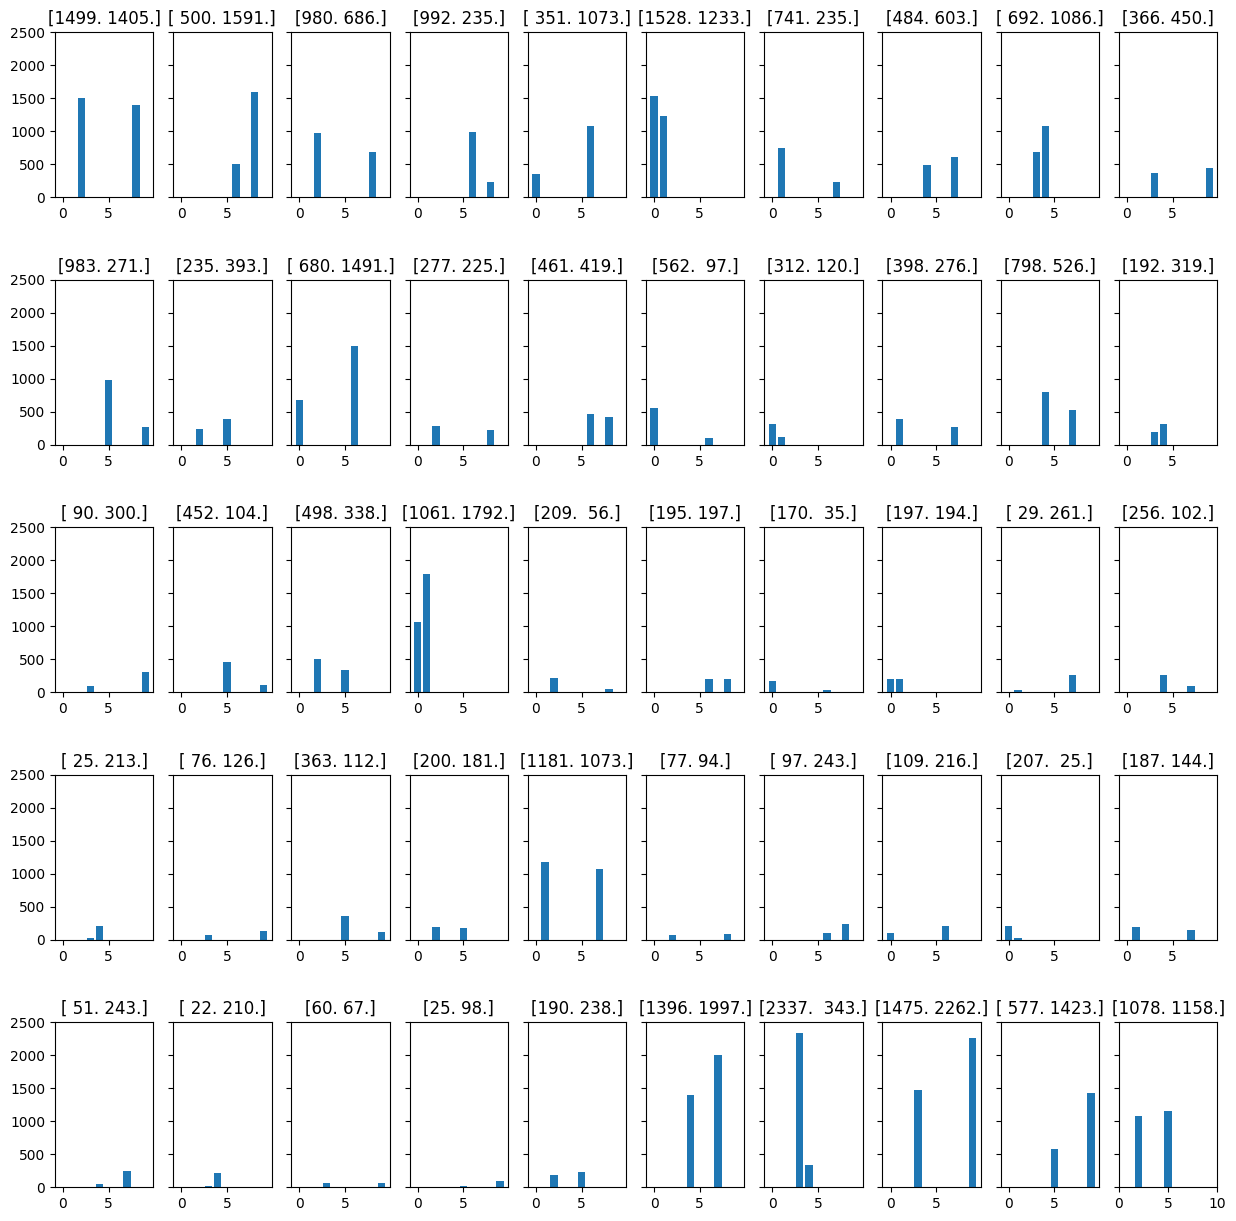

In [12]:
dir = './data/mnist/client_train/'
fig, axis = plt.subplots(nrows=5, ncols=10, figsize=(15, 15), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.xlim([0, 10])
plt.ylim([0, 2500])

list_dir = os.listdir(dir)
list_dir.sort()
for idx, file in enumerate(list_dir):
    with open(os.path.join(dir, file), 'r') as fi:
        data = json.load(fi)
    draw_distribution(data, axis.flat[idx], file)

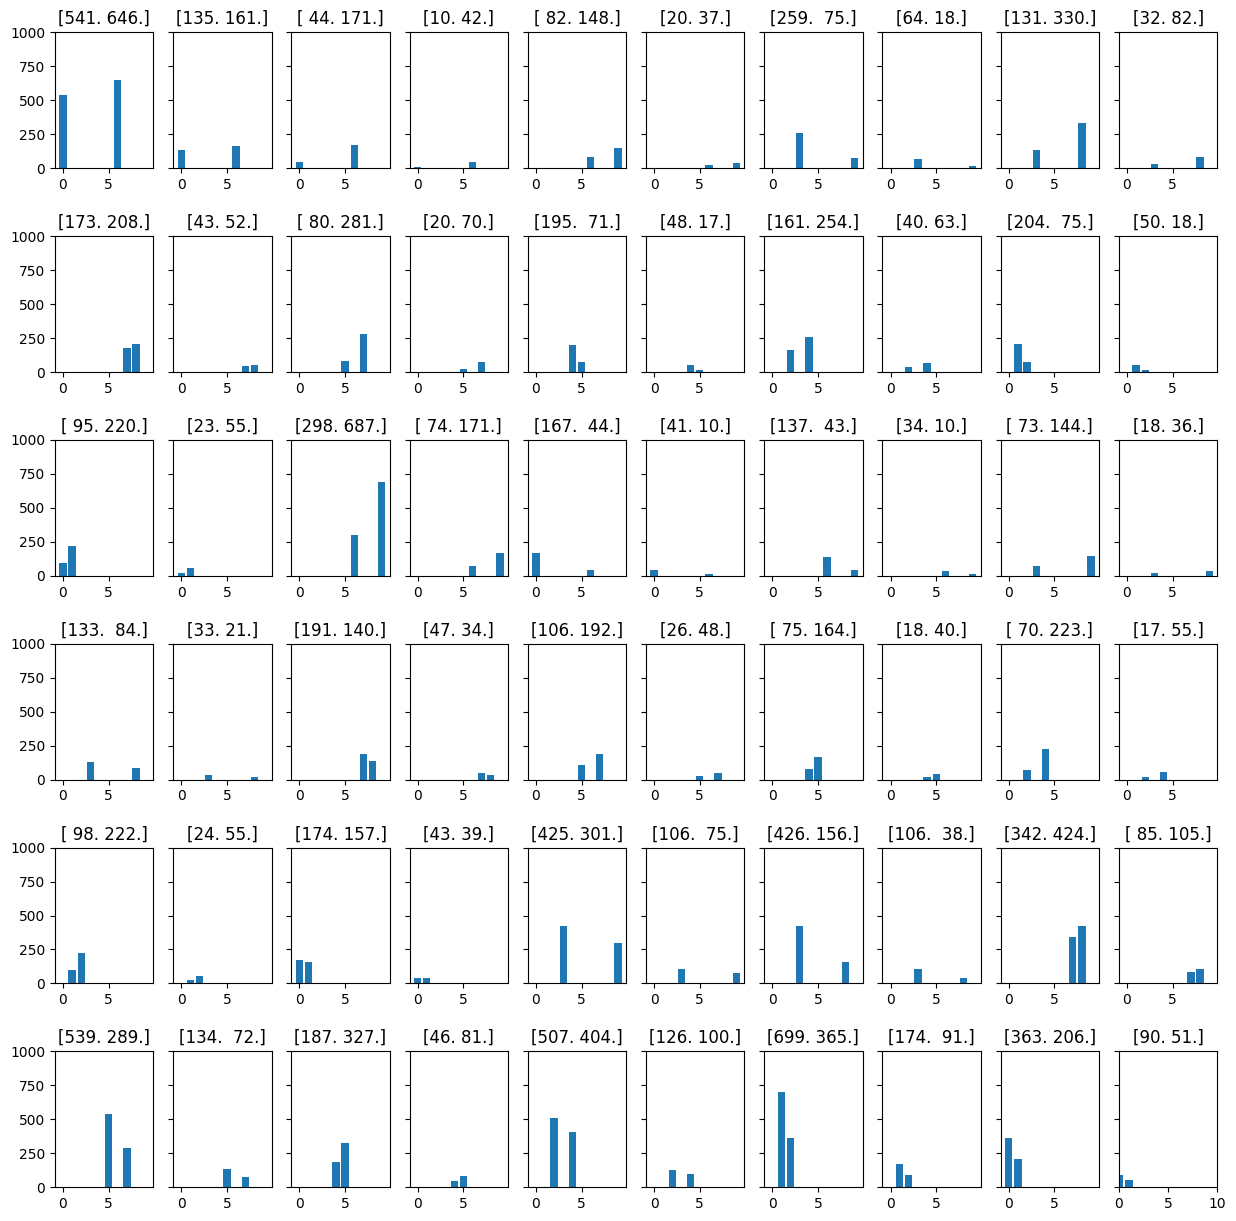

In [13]:
dir = './data/mnist/client_test/'
fig, axis = plt.subplots(nrows=6, ncols=10, figsize=(15, 15), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.xlim([0, 10])
plt.ylim([0, 1000])

list_dir = os.listdir(dir)
list_dir.sort()
for idx, file in enumerate(list_dir):
    with open(os.path.join(dir, file), 'r') as fi:
        data = json.load(fi)
    draw_distribution(data, axis.flat[idx], file)

---

## test mnist loader

In [1]:
from src.data.mnist_loader import get_loader
import matplotlib.pyplot as plt

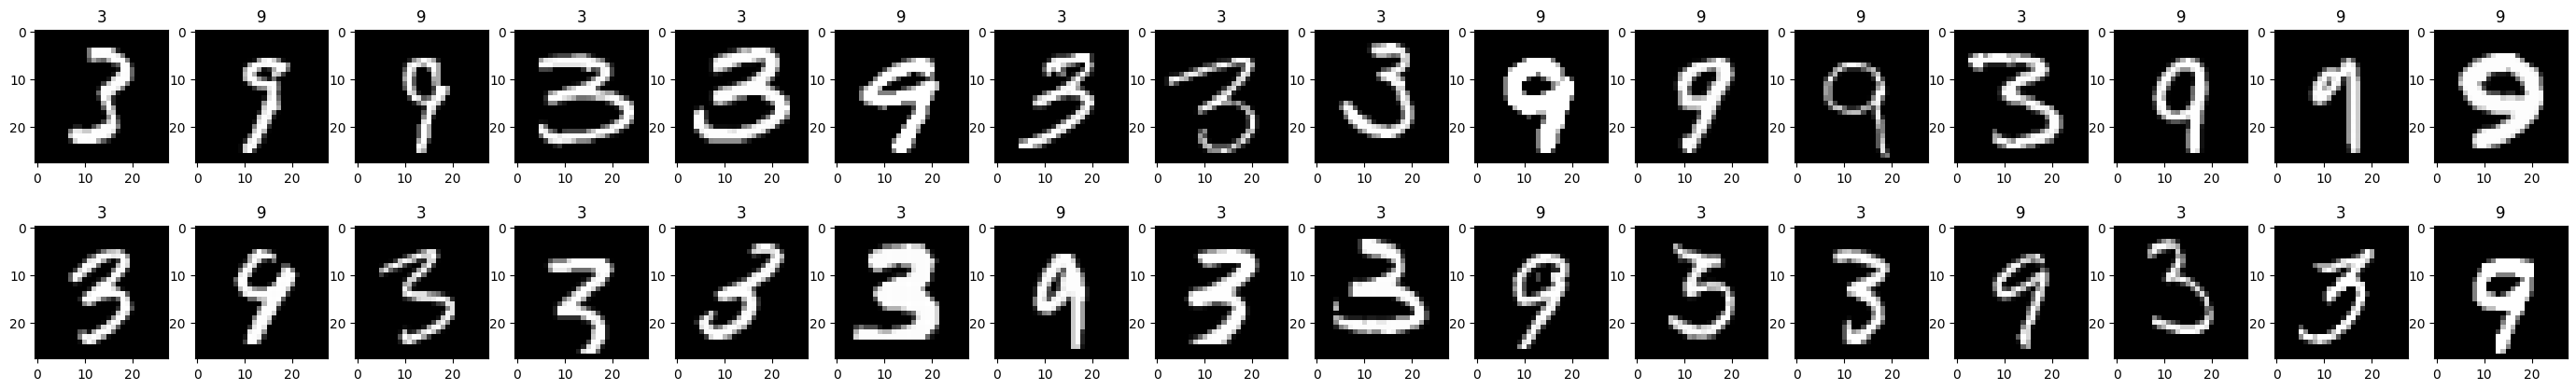

In [2]:
fig, axs = plt.subplots(nrows=2, ncols=16, figsize=(35,5))
count = 0
fig.subplots_adjust(hspace=0.2)

loader = get_loader('./data/mnist/client_test/2_s.json')
for batch in loader:
    for x, y in zip(batch[0], batch[1]):
        axs.flat[count].imshow(x.reshape((28,28)), cmap='gray')
        axs.flat[count].set_title(int(y))
        count += 1
    break

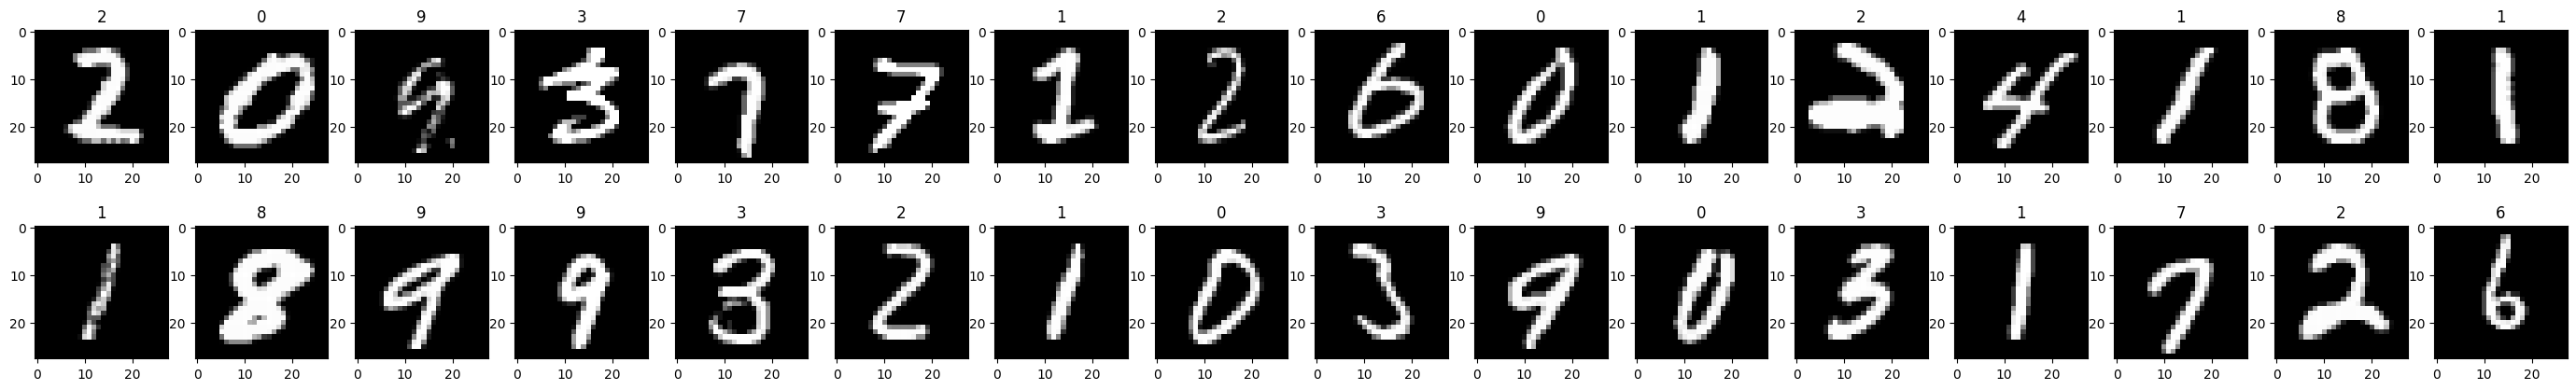

In [3]:
fig, axs = plt.subplots(nrows=2, ncols=16, figsize=(35,5))
count = 0
fig.subplots_adjust(hspace=0.2)

another_loader = get_loader('./data/mnist/mnist_test.csv')
for batch in another_loader:
    for x, y in zip(batch[0], batch[1]):
        axs.flat[count].imshow(x.reshape((28,28)), cmap='gray')
        axs.flat[count].set_title(int(y))
        count += 1
    break

---

## test loss function

In [6]:
import torch
from torch import nn
from src.model.mnist_model import Mnist
from src.data.mnist_loader import get_loader

In [7]:
model = Mnist()
loader = get_loader('./data/mnist/client_test/0_q.json')

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
for X, y in loader:
    print(X.size(), y.size())
    pred = model(X)
    print(pred.size())
    loss = loss_fn(pred, y)
    print(loss.item())
    break

torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 10])
2.3107831478118896


## test model mnist (centralized)

In [5]:
import torch
from torch import nn
from src.model.mnist_model import Mnist
from src.data.mnist_loader import get_loader

In [6]:
# data
train_loader = get_loader('./data/mnist/mnist_train.csv')
test_loader = get_loader('./data/mnist/mnist_test.csv')

In [3]:
# train
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        train_loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return train_loss, correct/size

In [4]:
# test
def test(dataloader, model, device):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    return test_loss, correct

In [12]:
# device
device = torch.device('cpu')
print(f'Using {device}')

Using cpu


In [13]:
# model
model = Mnist().to(device)
print(model)

# opt
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Mnist(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [11]:
%%time

# use mps
epochs = 15
for t in range(epochs):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer, device)
    print(f"Epoch {t+1}: Accuracy: {(100*train_acc):>0.1f}%, Loss: {train_loss:>8f}")
    if t == 0 or (t+1) % 5 == 0:
        test_loss, test_acc = test(test_loader, model, device)
        print(f"[Test] Epoch {t+1}:\n\tAccuracy: {(100*test_acc):>0.1f}%, Loss: {test_loss:>8f} \n")
print("Done!")

Epoch 1: Accuracy: 88.8%, Loss: 0.103946
[Test] Epoch 1:
	Accuracy: 93.2%, Loss: 0.007194 

Epoch 2: Accuracy: 94.2%, Loss: 0.409974
Epoch 3: Accuracy: 95.4%, Loss: 0.046626
Epoch 4: Accuracy: 96.2%, Loss: 0.096843
Epoch 5: Accuracy: 96.8%, Loss: 0.005839
[Test] Epoch 5:
	Accuracy: 95.7%, Loss: 0.004647 

Epoch 6: Accuracy: 97.1%, Loss: 0.014346
Epoch 7: Accuracy: 97.5%, Loss: 0.007959
Epoch 8: Accuracy: 97.8%, Loss: 0.156110
Epoch 9: Accuracy: 98.0%, Loss: 0.330228
Epoch 10: Accuracy: 98.2%, Loss: 0.035782
[Test] Epoch 10:
	Accuracy: 96.2%, Loss: 0.004296 

Epoch 11: Accuracy: 98.3%, Loss: 0.001033
Epoch 12: Accuracy: 98.5%, Loss: 0.004601
Epoch 13: Accuracy: 98.6%, Loss: 0.012465
Epoch 14: Accuracy: 98.7%, Loss: 0.008925
Epoch 15: Accuracy: 98.8%, Loss: 0.070133
[Test] Epoch 15:
	Accuracy: 96.6%, Loss: 0.004331 

Done!
CPU times: user 1min 27s, sys: 19.2 s, total: 1min 46s
Wall time: 2min 4s


In [14]:
%%time

# use cpu
epochs = 15
for t in range(epochs):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer, device)
    print(f"Epoch {t+1}: Accuracy: {(100*train_acc):>0.1f}%, Loss: {train_loss:>8f}")
    if t == 0 or (t+1) % 5 == 0:
        test_loss, test_acc = test(test_loader, model, device)
        print(f"[Test] Epoch {t+1}:\n\tAccuracy: {(100*test_acc):>0.1f}%, Loss: {test_loss:>8f} \n")
print("Done!")

Epoch 1: Accuracy: 89.3%, Loss: 0.737382
[Test] Epoch 1:
	Accuracy: 93.7%, Loss: 0.007210 

Epoch 2: Accuracy: 94.6%, Loss: 0.097975
Epoch 3: Accuracy: 95.8%, Loss: 0.163614
Epoch 4: Accuracy: 96.5%, Loss: 0.045844
Epoch 5: Accuracy: 97.0%, Loss: 0.142617
[Test] Epoch 5:
	Accuracy: 95.9%, Loss: 0.004476 

Epoch 6: Accuracy: 97.3%, Loss: 0.018591
Epoch 7: Accuracy: 97.6%, Loss: 0.048896
Epoch 8: Accuracy: 97.8%, Loss: 0.023071
Epoch 9: Accuracy: 98.1%, Loss: 0.144788
Epoch 10: Accuracy: 98.2%, Loss: 0.038365
[Test] Epoch 10:
	Accuracy: 96.2%, Loss: 0.004673 

Epoch 11: Accuracy: 98.4%, Loss: 0.029963
Epoch 12: Accuracy: 98.5%, Loss: 0.001534
Epoch 13: Accuracy: 98.6%, Loss: 0.003209
Epoch 14: Accuracy: 98.8%, Loss: 0.000722
Epoch 15: Accuracy: 98.9%, Loss: 0.021452
[Test] Epoch 15:
	Accuracy: 96.4%, Loss: 0.004480 

Done!
CPU times: user 16.4 s, sys: 10.3 s, total: 26.7 s
Wall time: 23.9 s


## model param

In [1]:
import torch
from torch import nn
from src.model.mnist_model import Mnist

In [2]:
model = Mnist()
model.parameters()

<generator object Module.parameters at 0x14666b5a0>

In [3]:
for p in model.parameters():
    p.data = torch.ones_like(p)
#     print(type(p.data))

for p in model.parameters():
    print(p)

Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], requires_grad=True)
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 

In [11]:
a = torch.Tensor([1,2,3])
b = a.clone()
id(a), id(b)

(4527462960, 4530756864)

## visualize train_log & test_log

In [1]:
import plotly.graph_objects as go
import json
import numpy as np

In [3]:
with open('./experiment/2023-03-17/17:44/description.json', 'r') as fi:
    command = json.load(fi)

with open('./experiment/2023-03-17/17:44/testing_log.json', 'r') as fi:
    testing_log = json.load(fi)

print(command, '\n\n', testing_log)

{'global_epochs': 15, 'global_lr': 0.001, 'local_epochs': 2, 'local_lr': 0.001, 'dataset': 'mnist', 'model': 'mnist', 'algorithm': 'fed_avg', 'client_per_round': 5, 'note': 'enter your node'} 

 {'losses': {'0': 0.07458110343878913, '4': 0.07392452860633472, '9': 0.07329781392293921, '14': 0.06418359263599828}, 'std_losses': {'0': 0.0055412677915530045, '4': 0.008266539179508587, '9': 0.015115985684171124, '14': 0.008127266706719842}, 'accs': {'0': 0.11106491065661496, '4': 0.15537811028445797, '9': 0.1433566265476546, '14': 0.4720717486238733}, 'std_accs': {'0': 0.23659433632860744, '4': 0.2071248160201938, '9': 0.2520322686451648, '14': 0.23636845090069974}}


In [7]:
x_test = np.array(list(testing_log['accs'].keys()), dtype=np.int16)
y_test = np.array([testing_log['accs'][key] * 100 for key in testing_log['accs'].keys()])
std_test = np.array([testing_log['std_accs'][key] * 100 for key in testing_log['std_accs'].keys()])

In [21]:
df.index.astype('int')

Int64Index([0, 4, 9, 14], dtype='int64')

In [57]:
import matplotlib.pyplot as plt

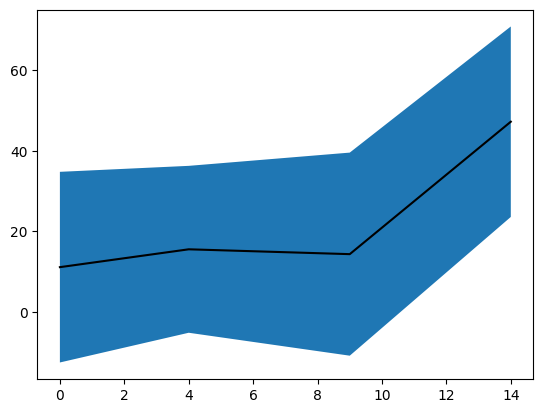

In [61]:
plt.plot(x_test, y_test, 'k-')
plt.fill_between(x_test, y_test-std_test, y_test+std_test)

## test meta model

In [8]:
import torch
from torch.utils.data import DataLoader
from src.data.mnist_loader import get_loader
from src.model.mnist_model import Mnist
import learn2learn as l2l
from copy import deepcopy

In [2]:
# data
support_loader = get_loader('./data/mnist/client_test/0_s.json')
query_loader = get_loader('./data/mnist/client_test/0_q.json')

In [9]:
# model
model = Mnist()
clone = deepcopy(model)
meta_model = l2l.algorithms.MAML(model=model, lr=0.1, first_order=False)

In [10]:
# opt + loss_fn
optimizer = torch.optim.SGD(meta_model.parameters(), 0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
def print_(models: list[torch.nn.Module]):
    for p, q in zip(models[0].parameters(), models[1].parameters()):
        print(p.data - q.data)

print_([model, meta_model])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [12]:
# outer loop
for i in range(10):
    outer_loss = 0
    learner = meta_model.clone()
    # inner loop: adapt model of task
    for j in range(2):
        for X, y in support_loader:
            pred = learner(X)
            loss = loss_fn(pred, y)
            learner.adapt(loss)
         
    # opt meta_model
    for X, y in query_loader:
        pred = learner(X)
        loss = loss_fn(pred, y)
        outer_loss += loss
        
    optimizer.zero_grad()
    outer_loss.backward()
    optimizer.step()

In [14]:
print_([model, meta_model])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [20]:
for p, q in zip(model_.parameters(), clone.parameters()):
    print(p.data - q.data)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([-2.8524e-03,  2.8932e-03,  6.8556e-03,  5.9264e-03,  5.5404e-02,
         4.8297e-02,  2.9389e-02,  3.6792e-02,  4.8951e-02,  4.5502e-02,
         1.3473e-03,  3.8562e-03,  1.7215e-02, -1.7467e-03,  2.2902e-02,
         2.1014e-02, -1.1357e-03,  4.2917e-02, -6.2321e-03, -8.9830e-05,
        -4.1897e-03,  2.4373e-02, -6.6387e-03,  5.6307e-03, -3.9857e-03,
         4.1033e-02, -1.2642e-03, -2.6495e-03,  3.7540e-02, -3.2286e-03,
        -1.6950e-03,  3.2008e-02,  1.6977e-03, -2.6122e-03,  1.2271e-02,
        -1.9887e-03, -5.0550e-03,  1.7677e-02,  4.8926e-02,  4.3371e-02,
        -8.2763e-04,  1.1617e-02,  1.8162e-02,  1.1539e-02,  1.7918e-02,
        -3.1348e-03,  1.7156e-02,  3.2888e-02,  2.0004e-03,  1.0095e-02,
        -1.8453e

In [19]:
from copy import deepcopy

model_ = Mnist()
opt = torch.optim.SGD(model_.parameters(), lr=0.1)
clone = deepcopy(model_)

for p in clone.parameters():
    print(p)
    print()
    break

for j in range(20):
    for X, y in support_loader:
        pred = model_(X)
        loss = loss_fn(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        
for p in model_.parameters():
    print(p)
    print()
    break

Parameter containing:
tensor([[ 0.0080,  0.0234,  0.0205,  ..., -0.0286, -0.0046, -0.0123],
        [-0.0174, -0.0226,  0.0314,  ..., -0.0316,  0.0113, -0.0282],
        [ 0.0079, -0.0266,  0.0331,  ..., -0.0193, -0.0048, -0.0300],
        ...,
        [ 0.0226, -0.0223, -0.0219,  ..., -0.0210,  0.0329,  0.0051],
        [-0.0222,  0.0280,  0.0326,  ..., -0.0196,  0.0044,  0.0022],
        [ 0.0183,  0.0240,  0.0322,  ..., -0.0154,  0.0355, -0.0065]],
       requires_grad=True)

Parameter containing:
tensor([[ 0.0080,  0.0234,  0.0205,  ..., -0.0286, -0.0046, -0.0123],
        [-0.0174, -0.0226,  0.0314,  ..., -0.0316,  0.0113, -0.0282],
        [ 0.0079, -0.0266,  0.0331,  ..., -0.0193, -0.0048, -0.0300],
        ...,
        [ 0.0226, -0.0223, -0.0219,  ..., -0.0210,  0.0329,  0.0051],
        [-0.0222,  0.0280,  0.0326,  ..., -0.0196,  0.0044,  0.0022],
        [ 0.0183,  0.0240,  0.0322,  ..., -0.0154,  0.0355, -0.0065]],
       requires_grad=True)

